## 4. 모델을 더 완벽하게 만드는 방법 : KerasTuner
* KerasTuner : MLOps는 하이퍼파라미터 튜닝

* MNIST로 간단하게 할 수 있는 하이퍼파라미터 튜닝작업

In [23]:
#!rm -rf ~/aiffel/my_keras_tuner

In [22]:
#!rm -rf /aiffel/aiffel/exp07/my_keras_tuner

In [25]:
#!rm -rf ~/aiffel/mlops

In [26]:
!mkdir ~/aiffel/mlops

In [27]:
!pip install keras-tuner

In [28]:
import tensorflow as tf
import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import os

In [29]:
# keras에 내장되어 있는 datasets : MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [31]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [32]:
#CNN을 사용할 예정이라 차원 수를 하나 더 추가
#label을 categorical을 활용해 변환
X_train = x_train.reshape(-1,28, 28, 1) 
X_test = x_test.reshape(-1,28,28,1)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [33]:
#train data와 validation data를 나누기
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)
print(X_train.shape)

(48000, 28, 28, 1)


#### 사용자정의 DeepTuner
* kerastuner.Tuner를 인자로 하는 class,
* class에서 수행하는 함수는 run_trial, save_model, load_model함수
* run_trial() -  hypermodel과 trial 중요
  - hypermodel: 모델을 공유 및 재사용하기 위해 검색 공간을 캡슐화하는 모델
  - 하이퍼파라미터 튜닝에 대한 검색공간을 만들어줄때 hp라는 인수를 사용해서 만든 모델
  - hp라는 인수를 활용해서 keras.Model을 생성
  - build 메소드를 활용하면 모델이 빌드가 되면서 하이퍼파라미터 튜닝이 시작
* trial : Oracle에 속하는 class
  - KerasTuner의 모든 검색 알고리즘에서 사용하는 기본 클래스
  - RandomSearchOracle, BayesianOptimizationOracle, HyperbandOracle
  - Oracle: 하이퍼파라미터를 정할 때 사용하는 알고리즘
  - trial.hyperparameter는 Oracle이 찾아야 하는 하이퍼파라미터
  - hypermodel에서의 hp
  - model.fit()을 할때 batch_size도 고를 수 있게 만들었음

In [34]:
# DeepTuner
class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        model.fit(X, y, batch_size=trial.hyperparameters.Choice(
            'batch_size', [16, 32]), **fit_kwargs)


        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        return {name: value for name, value in zip(
            model.metrics_names,
            eval_scores)}

#### build_model
* Input지정이 필수
* 여러분들이 넣고 싶은 모델에 대한 shape을 꼭 기재 -> 모델에 shape을 지정한다는 의미가???

In [35]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape = X_train.shape[1:], name = 'inputs'))
    for i in range(hp.Int('num_layers', min_value=1, max_value=10)):
              model.add(tf.keras.layers.Conv2D(hp.Int(
                  'units_{i}'.format(i=i), min_value=32, max_value=128, step=5), (3,3),activation='relu'))
    model.add(tf.keras.layers.Flatten())
    for i in range(hp.Int('n_connections', 1, 3)):
        model.add(tf.keras.layers.Dense(hp.Choice(f'n_nodes',
                                  values=[32,64,128, 256]), activation = 'relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax', name = 'outputs'))
    model.compile(optimizer = 'adam',loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

* keras_tuner를 정의하고 탐색
* BayesianOptimizationOracle을 사용할 예정
* 목표는 accuracy와 max로 둘 예정
* trial은 10번으로 지정

In [36]:
my_keras_tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'),
        max_trials=10,
        seed=42),
    hypermodel=build_model,
    overwrite=True,
    project_name='my_keras_tuner')

# 해당 모델 학습시간은 약 10분정도 걸립니다!
my_keras_tuner.search(
    X_train, y_train, validation_data=(X_val, y_val), epochs=3)

Trial 10 Complete [00h 00m 42s]
accuracy: 0.9778333306312561

Best accuracy So Far: 0.984499990940094
Total elapsed time: 00h 08m 19s


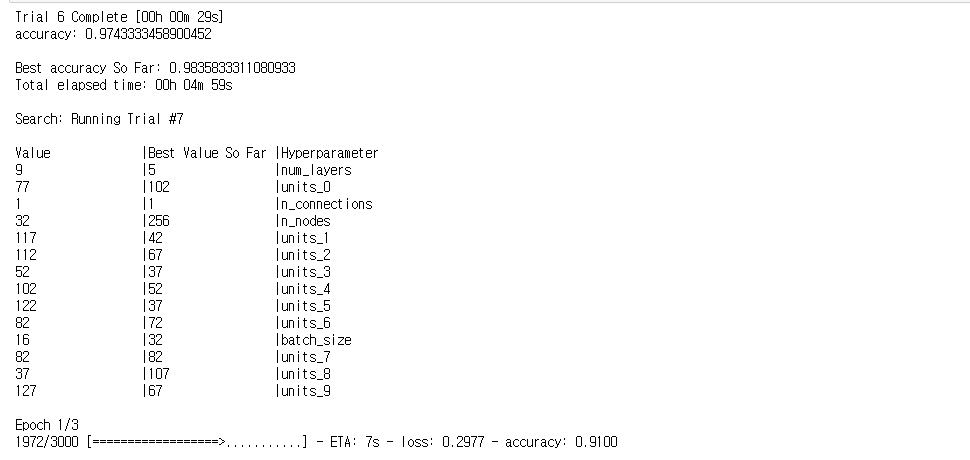

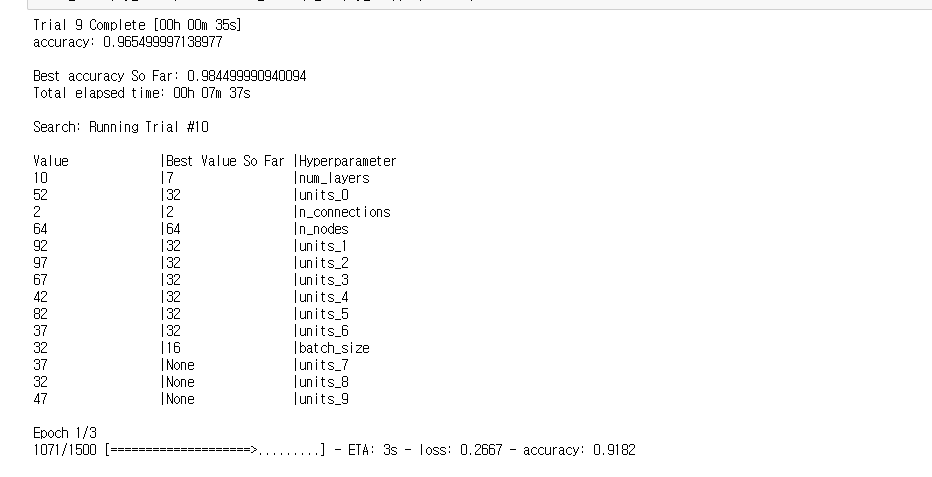

#### 가장 좋은 모델을 뽑는 방법은 KerasTuner.get_best_hyperparamters를 이용해서 가장 좋은 하이퍼파라미터를 뽑아내는 작업
* build_model()에 집어넣어 가장 좋은 모델을 선언

In [37]:
best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]
model = build_model(best_hps)
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_135 (Conv2D)          (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 24, 24, 32)        9248      
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 22, 22, 32)        9248      
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 20, 20, 32)        9248      
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 18, 18, 32)        9248      
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 14, 14, 32)      

* epoch을 5번정도 주어서 모델학습을 진행
* 하이퍼파라미터 튜닝할때 epoch을 3-4정도로 작게 준 다음 최고의 하이퍼파라미터를 뽑아낸 다음 본격적인 모델학습때 epoch을 넉넉하게 주는 것도 방법

In [38]:
model.fit(X_train, y_train, batch_size=32, epochs = 5)

Epoch 1/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1712 - accuracy: 0.9497
Epoch 2/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0671 - accuracy: 0.9802
Epoch 3/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0497 - accuracy: 0.9849
Epoch 4/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0402 - accuracy: 0.9882
Epoch 5/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0362 - accuracy: 0.9890


In [39]:
# 모델 평가를 진행
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0423 - accuracy: 0.9883


[0.04229220747947693, 0.9883000254631042]

### TensorFlow의 경우 공식적으로 지원하는 모델 저장방식은 SavedModel

* 이제 모델을 저장할 차례
* HDF5파일 (.h5)로 저장하는 방법
* SavedModel은 모델, 가중치를 따로 구분해서 저장하는 방식
  - saved_model.pb : pb는 프로토콜 버퍼를 의미하며 해당 파일은 내보낸 모델 그래프 구조를 포함
  - variables : 내보낸 변수값이 있는 이진 파일과 내보낸 모델 그래프에 해당하는 체크포인트를 포함
  - assets : 내보낸 모델을 불러올 때 추가적인 파일이 필요한 경우 이 폴더에 파일이 생성

In [40]:
save_path = os.getenv('HOME') + '/aiffel/mlops/best_model/1'
fname = os.path.join(save_path, 'model')
model.save(fname)

INFO:tensorflow:Assets written to: /aiffel/aiffel/mlops/best_model/1/model/assets


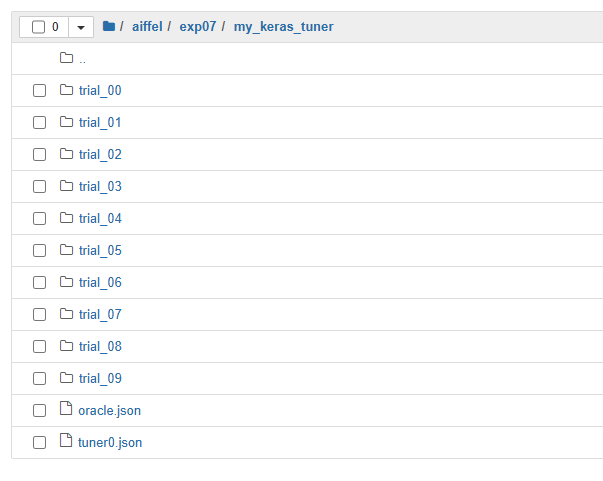

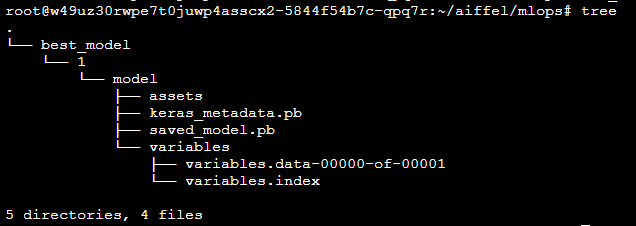

### 이제는 모델을 배포할 차례! : TFServing & TFLite

* 클라우드를 활용해서 모델을 배포하는 방식 ->  TFServing 방식
* 경량화된 모델을 만들어서 휴대폰같은 디바이스에서도 모델이 실행되게 만드는 방식 -> TFLite 방식

### TFServing
* 텐서플로우 그래프를 배포할 수 있으며 표준화된 엔드포인트를 제공
* 모델 및 버전관리가 가능하며 정책 기반으로 모델을 서비스할 수 있다
* TFServing을 하는 방식 2가지
  - Docker를 활용한 배포
  - 우분투 터미널을 활용한 배포

* 우분투 터미널 실습의 경우 실제 결과물이 나오려면 로컬에서 진행해야 합니다
* WSL2와 Docker 환경세팅 필요

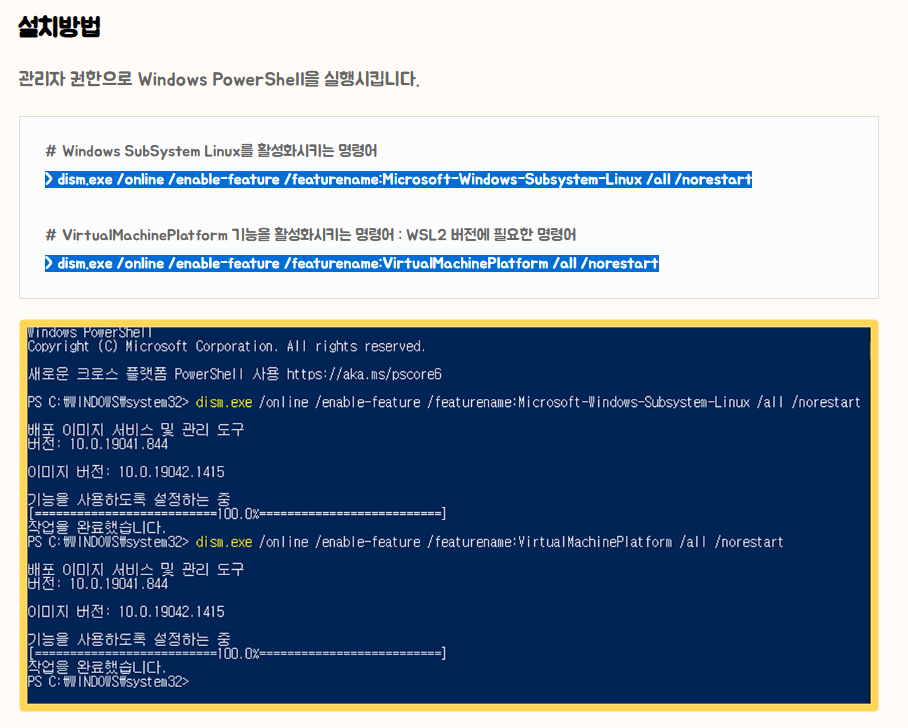

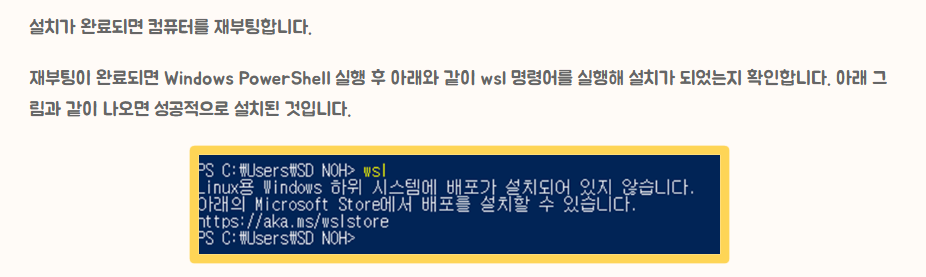